## Importing packages

In [24]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import layers


## Get data

In [46]:
data = pd.read_csv("COTACAO.csv", decimal=',')
data["Price"] = data["Último"]
data["Data"] = pd.to_datetime(data["Data"])
data["Date"] = data["Data"]
data = data[["Date","Price"]]
data.set_index("Date", inplace=True)
data = data.sort_values(by=["Date"], ascending=True)
data.head()

C:\Users\Windows 11\AppData\Local\Temp\ipykernel_15008\385172753.py:3: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data["Data"] = pd.to_datetime(data["Data"])


,Price
Date,
2024-02-01,4.9163
2024-02-02,4.9699
2024-02-05,4.9854
2024-02-06,4.9634
2024-02-07,4.9685


In [47]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 277 entries, 2024-02-01 to 2025-02-21
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   277 non-null    float64
dtypes: float64(1)
memory usage: 4.3 KB


## Building N-BEATS block layer

In [48]:
# Create NBeatBlock custom layer
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, 
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): # the **kwargs argument takes care of all the arguments for the parent class (input_shape, trainable, name)
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs):
    x = inputs
    for layer in self.hidden:
      x = layer(x)
    theta = self.theta_layer(x)
    # Output the backcast and the forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

## Preparing data for the N-BEATS algorithm using tf.data

In [49]:
HORIZON = 1
WINDOW_SIZE = 7 

In [50]:
# Add windowed columns
data_nbeats = data.copy()
for i in range(WINDOW_SIZE):
  data_nbeats[f"Price+{i+1}"] = data_nbeats["Price"].shift(periods=i+1)
data_nbeats.head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2024-02-01,4.9163,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-02-02,4.9699,4.9163,NaN,NaN,NaN,NaN,NaN,NaN
2024-02-05,4.9854,4.9699,4.9163,NaN,NaN,NaN,NaN,NaN
2024-02-06,4.9634,4.9854,4.9699,4.9163,NaN,NaN,NaN,NaN
2024-02-07,4.9685,4.9634,4.9854,4.9699,4.9163,NaN,NaN,NaN


In [51]:
# Make features and labels
X = data_nbeats.dropna().drop("Price", axis=1)
y = data_nbeats.dropna()["Price"]

# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(216, 216, 54, 54)

In [52]:
# Time to make our dataset performant using tf.data API
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# Combine labels and features by zipping together -> (features, labels)
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# Batch and prefetch
BATCH_SIZE = 1024
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [53]:
# Values from N-BEATS paper
N_EPOCHS = 5000
N_NEURONS = 512
N_LAYERS = 4 
N_STACKS = 30 

INPUT_SIZE = WINDOW_SIZE * HORIZON
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

In [54]:
# Make tensors
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

# Subtract
subtracted = layers.subtract([tensor_1, tensor_2])

# Add
added = layers.add([tensor_1, tensor_2])

# Get outputs
print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")

Input tensors: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]


In [55]:
%%time

tf.random.set_seed(42)

# 1. Setup and instance of NBeatsBlock
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE, 
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# 2. Create input to stack
stack_input = layers.Input(shape=(INPUT_SIZE,), name="stack_input")

# 3. Create initial backcast and forecast input (backwards prediction + horizon prediction)
residuals, forecast = nbeats_block_layer(stack_input)

# 4. Create stacks of block layers
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already created in (3)

  # 5. Use the NBeatsBlock to calculate the backcast as well as the forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass in the residuals

  # 6. Create the double residual stacking
  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}")
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model_7 = tf.keras.Model(inputs=stack_input, outputs=forecast, name="model_7_NBEATS")

# 8. Compile model with MAE loss
model_7.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model_7.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                        patience=200,
                                                        restore_best_weights=True),
                       tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                            patience=100,
                                                            verbose=1)])


Epoch 248: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 412: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 512: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
CPU times: total: 1min 2s
Wall time: 2min 32s


In [56]:
# Evaluate N-BEats model on the test dataset
model_7.evaluate(test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0428


0.04279206320643425

In [160]:
# Create a function to take in model predictions and truth values and return evaluation metrics
def evaluate_preds(y_true, y_pred):
  # Make sure float32 datatype (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various evaluation metrics 
  mae = tf.keras.metrics.mae(y_true, y_pred)
  mse = tf.keras.metrics.mse(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mape(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy()}

In [161]:
evaluate_preds(y_true=y_test[1:], y_pred=model_7.evaluate(test_dataset))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0428


{'mae': 5.9337964, 'mse': 35.239838, 'rmse': 5.936315, 'mape': 99.2834}

In [57]:
def make_preds(model, input_data):
  """
  Uses model to make predictions input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions
# Make predictions with N-BEATS model
model_7_preds = make_preds(model_7, test_dataset)
model_7_preds[:10]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([6.0145044, 6.0271645, 6.0056634, 5.9945393, 5.9893928, 6.024977 ,
       6.038296 , 6.090884 , 6.0881586, 6.092929 ], dtype=float32)>

In [150]:
# How many timestesp to predict into the future?
INTO_FUTURE = 7

def make_future_forecasts(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  """
  Make future forecasts into_future steps after values ends.

  Returns future forecasts as a list of floats.
  """
  # 2. Create an empty list for future forecasts/prepare data to forecast on
  future_forecast = []
  last_window = values[-WINDOW_SIZE:]

  # 3. Make INTO_FUTURE numer of predictions, altering the data which gets predicted on each
  for _ in range(INTO_FUTURE):
    # Predict on the last window then append it again, again, again (our model will eventually start to make forecasts on its own forecasts)
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on:\n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

    # Append predictions to future_forecast
    future_forecast.append(tf.squeeze(future_pred).numpy())

    # Update last window with new pred and get WINDOW_SIZE most recent preds (model was trained on WINDOW_SIZE windows)
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]
  
  return future_forecast

In [151]:
def get_future_dates(start_date, into_future, offset=1):
  """
  Returns array of datetime values ranging from start_date to start_date+into_future
  """
  start_date = start_date + np.timedelta64(offset, "D") # specify start date, "D" stands for day
  end_date = start_date + np.timedelta64(into_future, "D") # specify end date
  return np.arange(start_date, end_date, dtype="datetime64[D]") # return a date range between start and end date

In [152]:
# Make forecasts into the future
future_forecast = make_future_forecasts(values=y,
                                        model=model_7,
                                        into_future=INTO_FUTURE,
                                        window_size=WINDOW_SIZE)

# Insert last timestep/final price into next time steps and future forecasts so the plot doesn't look janky
last_timestep = data.index[-1]
next_time_steps = get_future_dates(start_date=last_timestep,
                                   into_future=INTO_FUTURE)
next_time_steps = np.insert(next_time_steps, 0, last_timestep)
future_forecast = np.insert(future_forecast, 0, data.Price[-1])
len(next_time_steps), len(future_forecast)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Predicting on:
 Date
2025-02-13    5.7669
2025-02-14    5.7042
2025-02-17    5.7130
2025-02-18    5.6892
2025-02-19    5.7214
2025-02-20    5.7029
2025-02-21    5.7320
Name: Price, dtype: float64 -> Prediction: 5.714555740356445

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicting on:
 [5.7042     5.713      5.6892     5.7214     5.7029     5.732
 5.71455574] -> Prediction: 5.699496269226074

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicting on:
 [5.713      5.6892     5.7214     5.7029     5.732      5.71455574
 5.69949627] -> Prediction: 5.699934005737305

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicting on:
 [5.6892     5.7214     5.7029     5.732      5.71455574 5.69949627
 5.69993401] -> Prediction: 5.698608875274658

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicting on:
 [5.7214     5.7029     5.732      5.71455574 5.69949627 5.69993401
 5.69860888] -> Prediction: 5.7047505378723145

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicting on:
 [5.7029   

C:\Users\Windows 11\AppData\Local\Temp\ipykernel_15008\3192174580.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  future_forecast = np.insert(future_forecast, 0, data.Price[-1])


(8, 8)

In [153]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format=".", start=0, end=None, label=None):
  """
  Plots timesteps (a series of points in time) against values (a series of values across timesteps).

  Parameters
  ----------
  timesteps : array of timestep values
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (similar to start but for the end)
  label : label to show on plot about values, default None 
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("Price")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

[5.732     5.7145557 5.6994963 5.699934  5.698609  5.7047505 5.70115
 5.7017164]


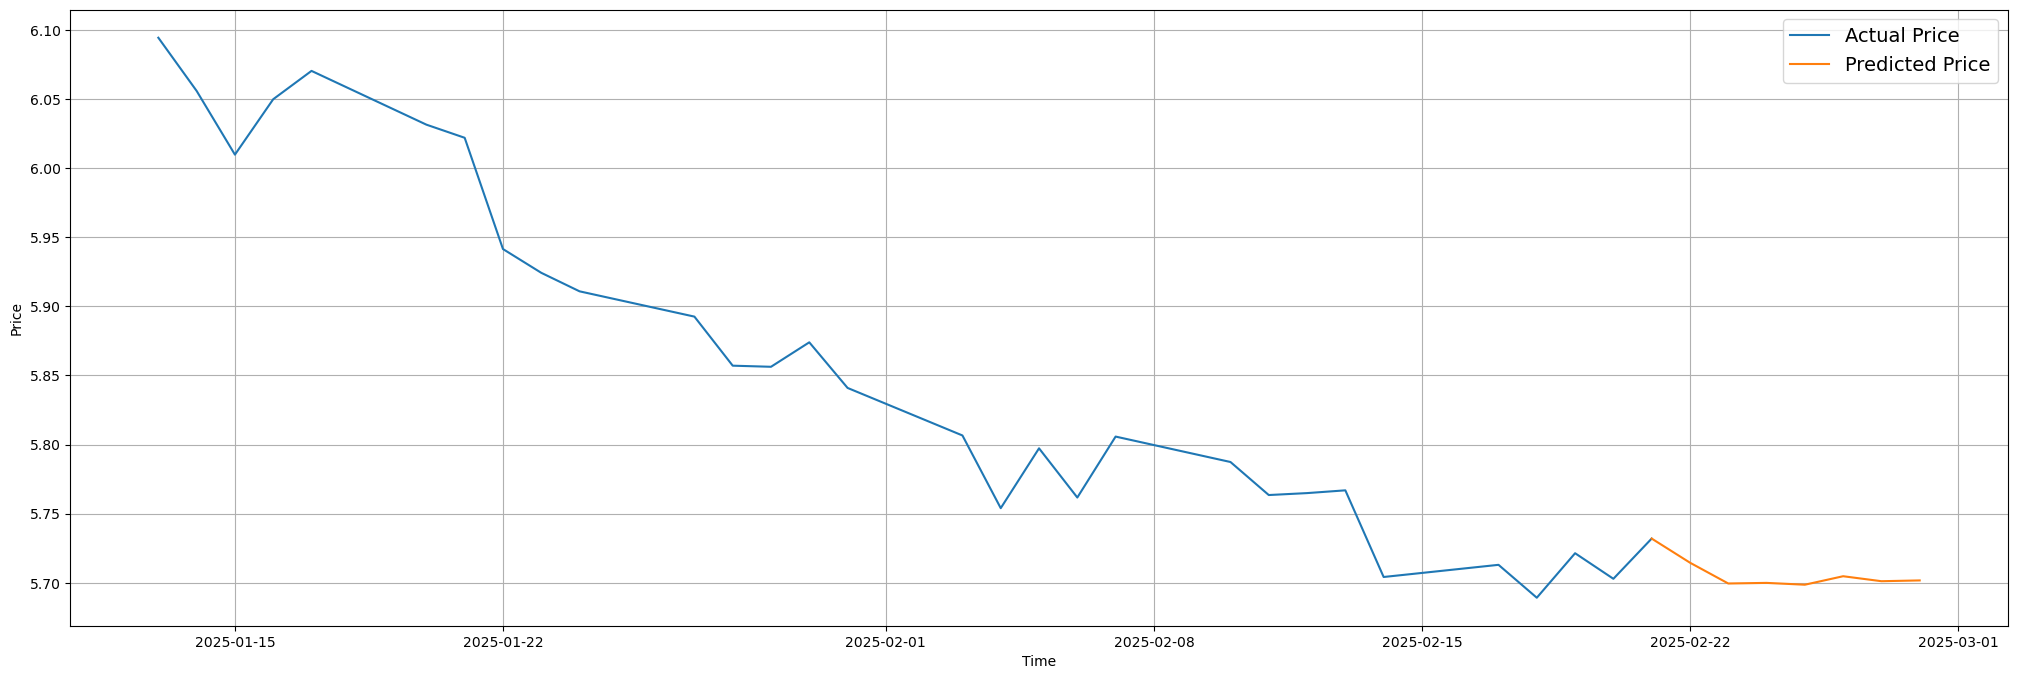

In [154]:
# Plot future prices predictions of Bitcoin
plt.figure(figsize=(25,8))
plot_time_series(data_to_plot.index, data_to_plot.Price, start=60, format="-", label="Actual Price")
plot_time_series(next_time_steps, future_forecast, format="-", label="Predicted Price")
print(future_forecast)